<a href="https://colab.research.google.com/github/kcarnold/cs344/blob/main/src/Data_Loading_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq fastbook

# Preamble

In [120]:
from fastai.data.all import *
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
path = untar_data(URLs.PETS) / "images"
path

Path('/root/.fastai/data/oxford-iiit-pet/images')

In [ ]:
path.ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_250.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_69.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_171.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_20.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_8.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_29.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_163.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_147.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_192.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_242.jpg')...]

In [ ]:
image_files = get_image_files(path)
image_files

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_250.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_69.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_171.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_20.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_8.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_29.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_163.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_147.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_192.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_242.jpg')...]

In [ ]:
set(path.ls()) - set(image_files)

{Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.mat'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.mat')}

# Splitting

In [ ]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
train, valid = splitter(image_files)
train, valid

((#5912) [5643,5317,5806,3460,613,5456,2968,3741,10,4908...],
 (#1478) [4512,4290,5770,706,2200,4320,6450,501,1290,6435...])

## Datasets, DataBlocks, and DataLoaders

### What we've seen before

In [ ]:
def cat_or_dog(x): return 'cat' if x[0].isupper() else 'dog'

dls = ImageDataLoaders.from_name_func(
    Path("/"),
    fnames=image_files,
    valid_pct=0.2,
    seed=42,
    label_func=cat_or_dog,
    item_tfms=Resize(224))

In [ ]:
dls.train.n

5912

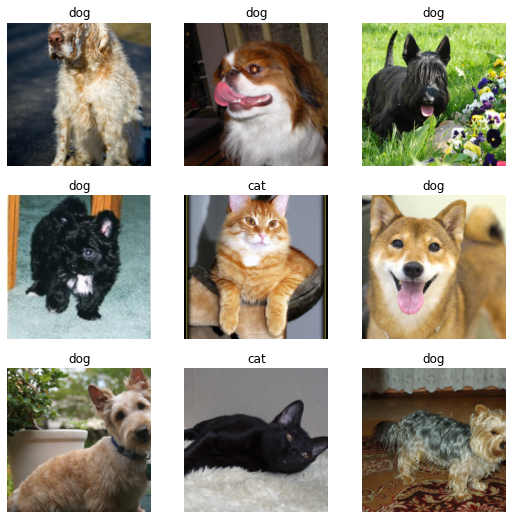

In [ ]:
dls.train.show_batch()

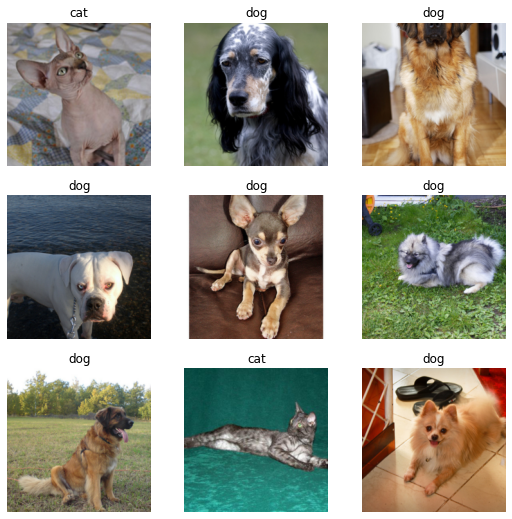

In [ ]:
dls.valid.show_batch()

### Peel back the onion...

Think of a *model* as a *function* from inputs X (e.g., images) to outputs *y* (e.g., labels):

f(X) -> y

The DataLoader's job is to give the model pairs of (X, y) in the right format so that it (hopefully) learns to make good y's for X's that it hasn't seen.

Let's get an example X. In this case, what we actually have is neither X or y but a *file name*; we'll get both X and y from it.

In [124]:
filename = image_files[0]
filename

Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_250.jpg')

How do we get an image (X)?

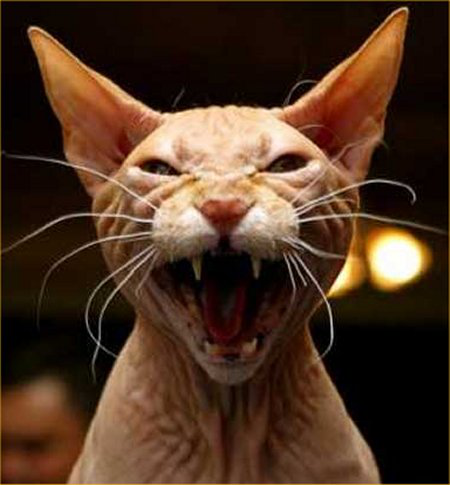

In [123]:
PILImage.create(filename)

I totally did not cherry-pick that photo! In seriousness, that's a step in the right direction, but it's still not in the format for a model to use. But let's see if we can take the first step towards a *y*:

In [127]:
print("Full name:", filename)
print("'name' attribute:", filename.name)
print("cat_or_dog:", cat_or_dog(filename.name))

Full name: /root/.fastai/data/oxford-iiit-pet/images/Sphynx_250.jpg
'name' attribute: Sphynx_250.jpg
cat_or_dog: cat


So we can bundle that two-step process into a function:

In [128]:
cat_or_dog(image_files[0].name)

'cat'

In [129]:
def get_y(file_path):
    return cat_or_dog(file_path.name)
get_y(image_files[0])

'cat'

We can also write it as an *anonymous* (lambda) function:

In [131]:
get_y = lambda file_path: cat_or_dog(file_path.name)
get_y(image_files[0])

'cat'

Now we can create a `DataBlock` using that!

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_y     = get_y,
                   splitter  = splitter,
                   item_tfms = Resize(224))

In [ ]:
my_dataloaders = dblock.dataloaders(image_files)

In [ ]:
my_dataloaders.train.n

5912

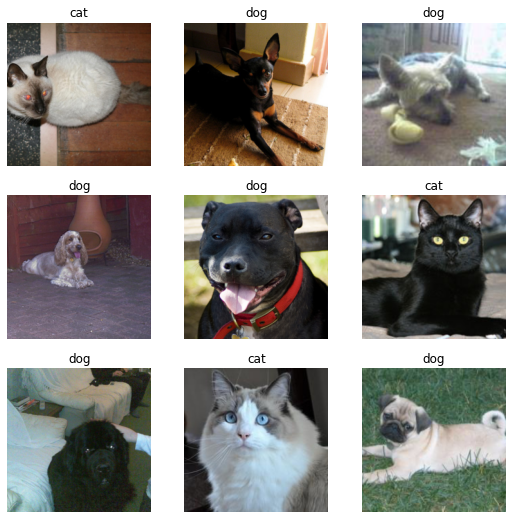

In [ ]:
my_dataloaders.train.show_batch()

### DataLoaders = Datasets + transforms (from DataBlock)

* **Datasets**: `train` and `valid` `Dataset`
* **Dataset**: a sequence of (X, y) pairs

**DataBlock** scaffolds construction, then gets out of the way.

A `Pipeline` of transformations takes the raw-ish (X, y) pairs and turns them into transformed batches. Let's see some examples:

In [135]:
my_dataloaders.train.dataset[0]

(PILImage mode=RGB size=500x388, TensorCategory(0))

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Sphynx_99.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x388
  Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Sphynx_99.jpg
    applying <lambda> gives
      cat
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=500x388, TensorCategory(0))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: R

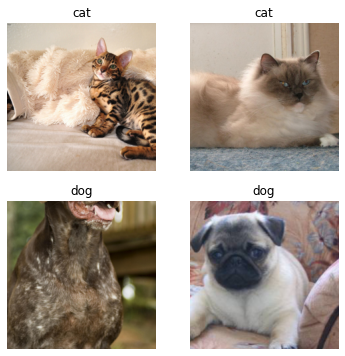

In [ ]:
my_dataloaders = dblock.summary(image_files, show_batch=True)

# Data Augmentation

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_y     = lambda filename: cat_or_dog(filename.name),
                   splitter  = splitter,
                   item_tfms = Resize(128),
                   batch_tfms= aug_transforms())
dblock.summary(image_files)
my_dataloaders = dblock.dataloaders(image_files, batch_size=8)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Sphynx_99.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x388
  Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Sphynx_99.jpg
    applying <lambda> gives
      cat
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=500x388, TensorCategory(0))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: R

In [ ]:
batch = my_dataloaders.one_batch()
images, labels = batch
images.shape

(8, 3, 128, 128)

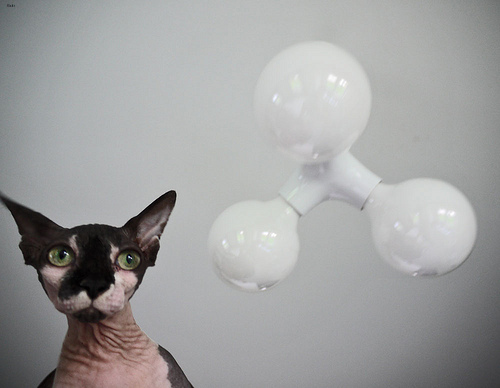

In [ ]:
my_dataloaders.train.dataset[0][0]

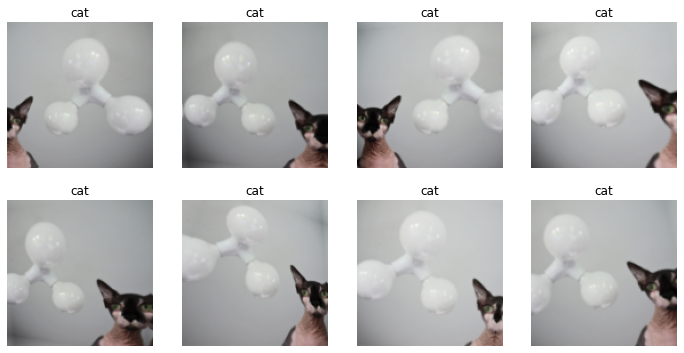

In [ ]:
my_dataloaders.train.show_batch(unique=True)